<a href="https://colab.research.google.com/github/We1rdguy/MNIST/blob/master/Pytorch_CNN_MNIST_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imort useful tools


In [0]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe
import os


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchsummary import summary
from sklearn.model_selection import train_test_split

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import confusion_matrix
%matplotlib inline

# Loading Data from Google Drive


In [23]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
dataset_path="gdrive/My Drive/Dataset/MNIST"
os.chdir(dataset_path)

FileNotFoundError: ignored

In [25]:
! ls

digit-recognizer.zip  model_01.pth  sample_submission.csv  train.csv
graph.png	      model.pth     test.csv


#  Training and Test data

In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

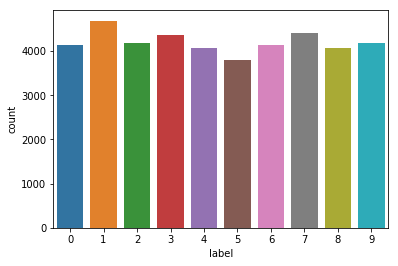

In [81]:
Y_train = train['label']
X_train = train.drop(['label'],1)


# del train


g = sns.countplot(Y_train)
train['label'].value_counts()


In [82]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [83]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [84]:
# Normalize data

# X_train = X_train / 255.0
# test = test / 255.0

print(X_train.shape)
print(test.shape)

# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

(42000, 784)
(28000, 784)


In [85]:
print(X_train.shape)
print(test.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)


In [0]:
# Set the random seed
random_seed = 2


# Split the train and the validation set for the fitting
x_train, x_val, y_train, y_val = train_test_split(X_train,
                                                  Y_train.values,
                                                  test_size = 0.2,
                                                  random_state=random_seed)

In [87]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(33600, 28, 28, 1)
(8400, 28, 28, 1)
(33600,)
(8400,)


In [88]:
y_train[20].dtype

dtype('int64')

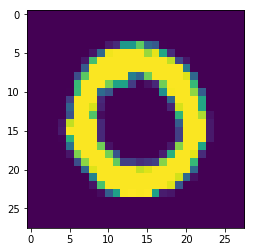

In [89]:
# Some examples
g = plt.imshow(X_train[1][:,:,0])

# CNN Model 

In [90]:

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
    self.conv3 = nn.Conv2d(32,64, kernel_size=5)
    self.fc1 = nn.Linear(3*3*64, 256)
    self.fc2 = nn.Linear(256, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.dropout(x, p=0.5, training=self.training)
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    x = F.dropout(x, p=0.5, training=self.training)
    x = F.relu(F.max_pool2d(self.conv3(x),2))
    x = F.dropout(x, p=0.5, training=self.training)
    x = x.view(-1,3*3*64 )
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

learning_rate=0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
criterion = nn.CrossEntropyLoss()

# Print model's state_dict

# summary(model, (1, 28, 28))


print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])      
    
print("Model summary:")
summary(model, (1, 28, 28))

Model's state_dict:
conv1.weight 	 torch.Size([32, 1, 5, 5])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([32, 32, 5, 5])
conv2.bias 	 torch.Size([32])
conv3.weight 	 torch.Size([64, 32, 5, 5])
conv3.bias 	 torch.Size([64])
fc1.weight 	 torch.Size([256, 576])
fc1.bias 	 torch.Size([256])
fc2.weight 	 torch.Size([10, 256])
fc2.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 1e-05, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [140541468114520, 140541468113008, 140541468114304, 140541468112360, 140541468111136, 140541468111640, 140541468111064, 140541468114376, 140541468114736, 140541468112720]}]
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
            Conv2d-2           [-1, 32, 20, 20]          25,632
            Conv2d-3             [-1, 64, 6

** Batch data **

In [0]:
BATCH_SIZE = 64
n_iters = 2500
num_epochs = n_iters / (len(y_train) / BATCH_SIZE)
num_epochs = int(num_epochs)
EPOCHS=20

torch_X_train = torch.from_numpy(x_train).type(torch.LongTensor)
torch_Y_train = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
torch_X_val = torch.from_numpy(x_val).type(torch.LongTensor)
torch_Y_val = torch.from_numpy(y_val).type(torch.LongTensor) # data type is long



torch_X_train = torch_X_train.view(-1, 1,28,28).float().cuda()
torch_X_val = torch_X_val.view(-1,1,28,28).float().cuda()

# Pytorch train and valid sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_Y_train)
val = torch.utils.data.TensorDataset(torch_X_val,torch_Y_val)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
val_loader = torch.utils.data.DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

In [53]:
print(num_epochs)
print(torch_X_train.shape)
print(torch_X_val.shape)

2
torch.Size([33600, 1, 28, 28])
torch.Size([8400, 1, 28, 28])


In [18]:
print(torch_Y_val[0])

tensor(6)


In [92]:
it = iter(train_loader)
X_batch, y_batch = next(it)
print(model.forward(X_batch).shape)

torch.Size([32, 10])


In [74]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(EPOCHS):
  for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
    var_X_batch = Variable(X_batch).cuda()
    var_y_batch = Variable(y_batch).cuda()
    
    # Clear gradients
    optimizer.zero_grad()
    
    # Forward propagation
    outputs = model(var_X_batch)
    
    # Calculate softmax and ross entropy loss
    loss = criterion(outputs, var_y_batch)
    
    # Calculating gradients
    loss.backward()
    
    # Update parameters
    optimizer.step()
    count += 1
    
    if count % 50 == 0:
      # Calculate Accuracy         
      correct = 0
      total = 0
      for val_images, val_labels in val_loader:
        var_val_images=Variable(val_images)
        
        outputs = model(var_val_images)
        predicted = torch.max(outputs.data, 1)[1] 
        
        # Total number of labels
        total += len(var_y_batch)
        correct += (predicted == val_labels.cuda()).sum()
      accuracy = 100 * correct / float(total)
      
      # store loss and iteration
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)
      if count % 500 == 0:
          # Print Loss
          print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))
    
    


Iteration: 500  Loss: 0.5303150415420532  Accuracy: 80 %
Iteration: 1000  Loss: 0.5386751294136047  Accuracy: 81 %
Iteration: 1500  Loss: 0.6130690574645996  Accuracy: 82 %
Iteration: 2000  Loss: 0.18475234508514404  Accuracy: 82 %
Iteration: 2500  Loss: 0.6551680564880371  Accuracy: 83 %
Iteration: 3000  Loss: 0.7211384177207947  Accuracy: 84 %
Iteration: 3500  Loss: 0.5939787030220032  Accuracy: 84 %
Iteration: 4000  Loss: 0.8705078959465027  Accuracy: 85 %
Iteration: 4500  Loss: 0.3569573163986206  Accuracy: 85 %
Iteration: 5000  Loss: 0.18972553312778473  Accuracy: 86 %
Iteration: 5500  Loss: 0.47217094898223877  Accuracy: 86 %
Iteration: 6000  Loss: 0.46535080671310425  Accuracy: 86 %
Iteration: 6500  Loss: 0.20267871022224426  Accuracy: 86 %
Iteration: 7000  Loss: 0.4798766076564789  Accuracy: 87 %
Iteration: 7500  Loss: 0.460138738155365  Accuracy: 87 %
Iteration: 8000  Loss: 0.6918459534645081  Accuracy: 87 %
Iteration: 8500  Loss: 0.4458097219467163  Accuracy: 88 %
Iteration: 

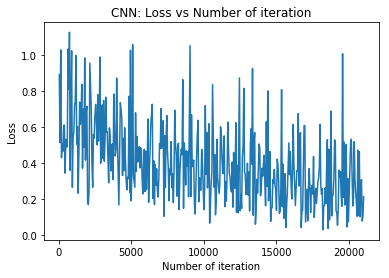

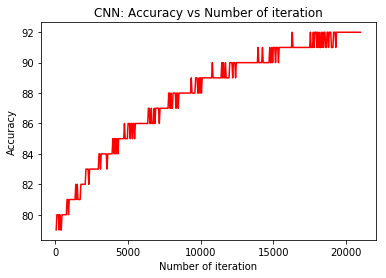

In [101]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [0]:
def fit(model, train_loader):
  
  
    count = 0
    loss_list = []
    iteration_list = []
    accuracy_list = []
    
    criterion  = nn.CrossEntropyLoss()
    EPOCHS = 30
    model.train()
    for epoch in range(EPOCHS):
      correct = 0
      for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).cuda()
        var_y_batch = Variable(y_batch).cuda()
        

        optimizer.zero_grad()
        output = model(var_X_batch)
        loss = criterion(output, var_y_batch)
        loss.backward()
        optimizer.step()
        count += 1
        
        # Total correct predictions
        predicted = torch.max(output.data, 1)[1] 
        
        correct += (predicted == var_y_batch).sum().cuda()
        
        #print(correct)
        if batch_idx % 50 == 0:
          # Calculate Accuracy         
          correct = 0
          total = 0
          
          for val_images, val_labels in val_loader:
            var_val_images=Variable(val_images)
        
            outputs = model(var_val_images)
            predicted = torch.max(outputs.data, 1)[1] 
            
            # Total number of labels
            total += len(var_y_batch)
            correct += (predicted == val_labels.cuda()).sum()
            
          accuracy = 100 * correct / float(total)
          # store loss and iteration
          loss_list.append(loss.data)
          iteration_list.append(count)
          accuracy_list.append(accuracy)
          
          
          print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
              epoch, 
              batch_idx*len(X_batch), 
              len(train_loader.dataset), 
              100.*batch_idx / len(train_loader), 
              loss.data, 
              accuracy))
          
          
          
          

          

In [99]:
fit(model,train_loader)

Epoch : 0 [0/33600 (0%)]	Loss: 1.445977	 Accuracy:50.000%
Epoch : 0 [3200/33600 (10%)]	Loss: 1.354292	 Accuracy:50.000%
Epoch : 0 [6400/33600 (19%)]	Loss: 1.469144	 Accuracy:50.000%
Epoch : 0 [9600/33600 (29%)]	Loss: 1.183415	 Accuracy:50.000%
Epoch : 0 [12800/33600 (38%)]	Loss: 1.436738	 Accuracy:51.000%
Epoch : 0 [16000/33600 (48%)]	Loss: 1.571108	 Accuracy:52.000%
Epoch : 0 [19200/33600 (57%)]	Loss: 1.344626	 Accuracy:53.000%
Epoch : 0 [22400/33600 (67%)]	Loss: 1.546747	 Accuracy:53.000%
Epoch : 0 [25600/33600 (76%)]	Loss: 1.409317	 Accuracy:54.000%
Epoch : 0 [28800/33600 (86%)]	Loss: 1.480958	 Accuracy:54.000%
Epoch : 0 [32000/33600 (95%)]	Loss: 1.408155	 Accuracy:55.000%
Epoch : 1 [0/33600 (0%)]	Loss: 1.300982	 Accuracy:55.000%
Epoch : 1 [3200/33600 (10%)]	Loss: 1.242287	 Accuracy:56.000%
Epoch : 1 [6400/33600 (19%)]	Loss: 1.285126	 Accuracy:57.000%
Epoch : 1 [9600/33600 (29%)]	Loss: 1.291798	 Accuracy:57.000%
Epoch : 1 [12800/33600 (38%)]	Loss: 1.214556	 Accuracy:57.000%
Epoch : 

In [100]:

PATH=dataset_path+"/model.pth"
print(PATH)
torch.save(model.state_dict(), "model_01.pth")

gdrive/My Drive/Dataset/MNIST/model.pth


In [0]:


model = CNN()
model.load_state_dict(torch.load( "model.pth"))
model.eval()


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [0]:
def evaluate(model):
  correct = 0
  correct=correct
  for val_imgs, val_labels in val_loader:
    #print(test_imgs.shape)
    val_imgs = Variable(val_imgs).float().cpu()
    output = model(val_imgs)
    predicted = torch.max(output,1)[1]
    correct += (predicted == val_labels).sum()
    
  print("Test accuracy:{:.3f}% ".format( float(correct) / (len(val_loader)*BATCH_SIZE)))

  


In [0]:
evaluate(model)

Test accuracy:0.978% 
